#### TODO

- [ ] Generate the random dispersing centers
- [ ] Define the free space Green's function
- [ ] Create the M matrix
- [ ] solve the linear system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.special import hankel1
from scipy.constants import pi, hbar

Defining the energy as:

$$E'=\frac{\hbar^2k^2}{2m}$$

We can extract $k$ as:

$$k=\sqrt{\frac{2mE'}{\hbar^2}}$$

But, energy is given in units of $E_0=\frac{\hbar^2}{md^2}$, such that $E=E'/E_0$, so we can write:

$$k=\sqrt{\frac{2mE'}{\hbar^2}}=\sqrt{\frac{2mE_0E}{\hbar^2}}=\sqrt{\frac{2E}{d^2}}$$

In [2]:
def generate_circular_lattice(n):
    x = np.linspace(-1, 1, n)
    y = np.linspace(-1, 1, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= 1

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [3]:
def generate_circular_lattice(radius=2, spacing=0.01, n=None):
    if n is None:
        n = int(radius/spacing)
    
    x = np.linspace(-radius, radius, n)
    y = np.linspace(-radius, radius, n)
    X, Y = np.meshgrid(x, y)

    # mask out the points outside the circle
    R = np.sqrt(X**2 + Y**2)
    mask = R <= radius

    # generate a mesh of points in the circle
    X = X[mask]
    Y = Y[mask]
    return X, Y

Careful with the units, as the energy is given in units of $E_0$, the wavevector is given in units of $1/d$.

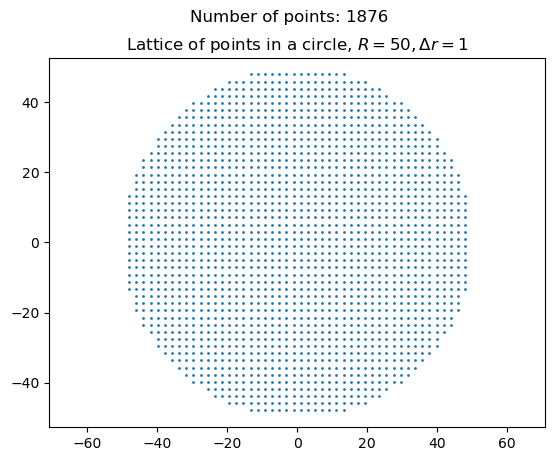

In [4]:
R=50
spacing=1

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

plt.scatter(X, Y, s=1)
plt.title(f'Lattice of points in a circle, $R={R}, \Delta r={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')

plt.axis('equal');

Number of dispersors: 125


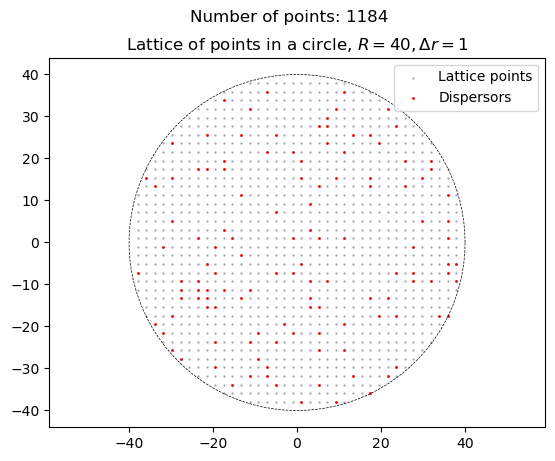

In [21]:
R=40
# spacing=0.04

X,Y=generate_circular_lattice(radius=R, spacing=spacing)

# choose each point with probability p
p=.1
np.random.seed(42) # !!!for reproducibility
mask = np.random.rand(len(X)) < p
X_dispersors=X[mask]
Y_dispersors=Y[mask]

plt.scatter(X, Y, s=1, label='Lattice points', color=(0,0,0,0.2))
plt.scatter(X_dispersors, Y_dispersors, s=1, label='Dispersors', c='r')
plt.title(f'Lattice of points in a circle, $R={R}, \Delta r={spacing}$')
plt.suptitle(f'Number of points: {len(X)}')
print(f'Number of dispersors: {len(X_dispersors)}')
# plot a circle of radius R
t = np.linspace(0, 2*pi, 100)
plt.plot(R*np.cos(t), R*np.sin(t), 'k--', linewidth=0.5)
plt.legend()
plt.axis('equal');


This verifies the continuum limit which is that the area of a circle is given by $A=\pi (l/2)^2$, and the area of a square is given by $A=l^2$, so:

$$\frac{A_{circle}}{A_{square}}=\frac{\pi (l/2)^2}{l^2}=\frac{\pi}{4}\sim 0.785398...\to A_{circle}=\frac{\pi}{4}A_{square}\approx_{N\to \infty} N_{circle}=\frac{\pi}{4}N_{square}$$

# Linear system of equations

The linear system of equations is given by:

$$\sum_{j=1}^{N}M_{ij}D_j=\frac{i\pi}{2}H_0^{(1)}(k(r_i-r_0))$$

Where $M_{ij}$ is given by:

$$M_{ij}=\left \{\begin{matrix}-\frac{i\pi}{2}H_0^{(1)}(k(r_i-r_j))& i\neq j\\\ln{\left(\frac{ka_{eff}e^\gamma}{2}\right)}-\frac{i\pi}{2} & i=j\end{matrix}\right.$$

In [22]:
m_matrix = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
energy = 1
d=1
a_eff = 2.2
k=np.sqrt(2*energy)/d

gamma_euler = 0.57721566490153286060

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            m_matrix[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            m_matrix[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
            
# plt.imshow(np.abs(m_matrix), cmap='viridis')

In [23]:
def generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors):
    diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
    off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

    for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
        for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
            if i == j:
                diagonal_terms[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
            else:
                off_diagonal_terms[i, j] = -1j*np.pi/2*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))
    return diagonal_terms, off_diagonal_terms

diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)
off_diagonal_terms = np.zeros((len(X_dispersors), len(Y_dispersors)), dtype=np.complex128)

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    for j, (x_prime, y_prime) in enumerate(zip(X_dispersors, Y_dispersors)):
        if i == j:
            diagonal_terms[i, j] = np.log(k*a_eff*np.exp(gamma_euler))-1j*np.pi/2
        else:
            off_diagonal_terms[i, j] = -1j*np.pi/4*hankel1(0, k*np.sqrt((x-x_prime)**2+(y-y_prime)**2))

In [24]:
off_diagonal_eigvals, off_diagonal_eigvecs = np.linalg.eig(off_diagonal_terms)

# plt.plot(np.real(off_diagonal_eigvals), np.imag(off_diagonal_eigvals), 'o')

In [25]:
new_eigvals = np.log(a_eff*k*np.exp(gamma_euler))-1j*np.pi/2+off_diagonal_eigvals
# plt.plot(np.real(new_eigvals), np.abs(np.imag(new_eigvals)), 'o',markersize=1)
# plt.semilogy()

1.1751511890216717
1.0548325546720587
1.029508970728629
0.9546013051600797
0.9458193333982567
0.8668672153087007
0.8439232356520625
0.8038824250293706
0.7999861446799565
0.637011606741317
0.5949747391648605
0.5899276274512157
0.5308674039854564
0.4885008326201259
0.5524841787035912
0.5095009521975333
0.5851845389554962
0.5826466107374344
0.5786299788384621
0.33270875820872714
0.21940836786541773


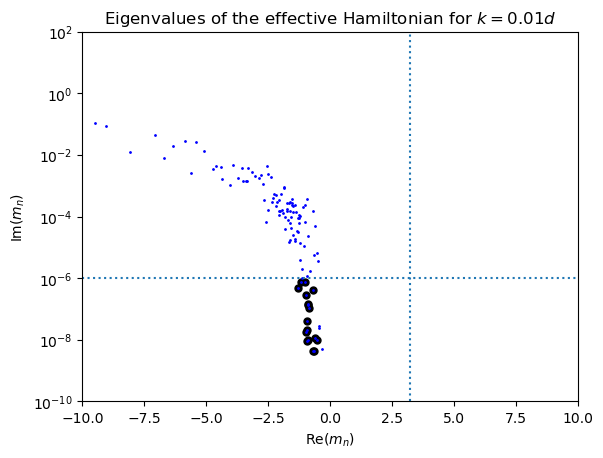

1.1749144054915073
1.0545179869541093
1.0291769057422053
0.9542112038085295
0.945344299129411
0.8663398714487647
0.8434454810161491
0.8030790491239248
0.6363424861807268
0.5942322063744507
0.5891720741119286
0.5299115476541005
0.5084965778093244
0.5515879841417934
0.5844128204030259
0.5818468815556184
0.577831984889634


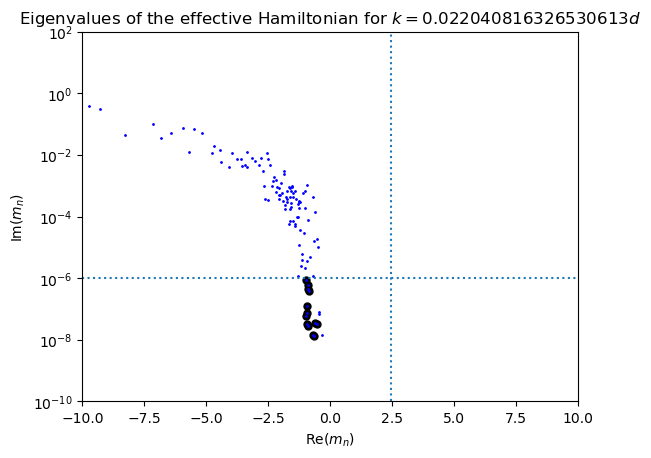

1.1744992941097916
1.0539662967762835
1.0285945124593336
0.9535268204352332
0.944510532676361
0.8654143442509561
0.8426073611013836
0.8016637899800267
0.6351684378297899
0.5929291408267345
0.5500135467533878
0.5282324045669631
0.5804428060144446
0.5764311353903673


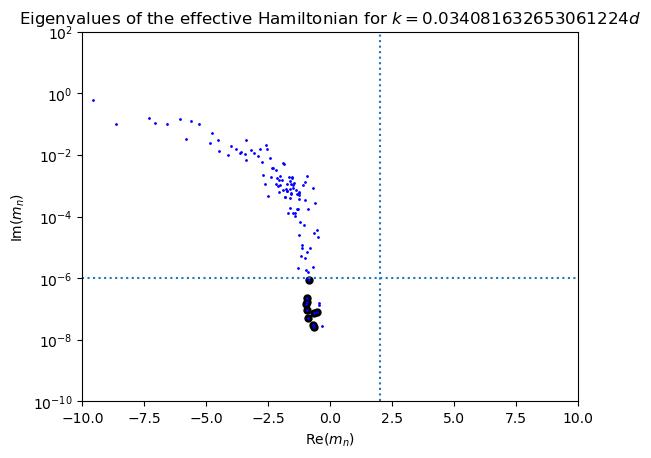

1.1739052515638493
1.0531763139552384
1.0277605275137973
0.9525463503114251
0.9433152211721816
0.8640875876881284
0.8414067442373225
0.7996229764733824
0.5910614911431682
0.5784289209442997
0.5744222963831236
0.547753109631258
0.5258218872251055


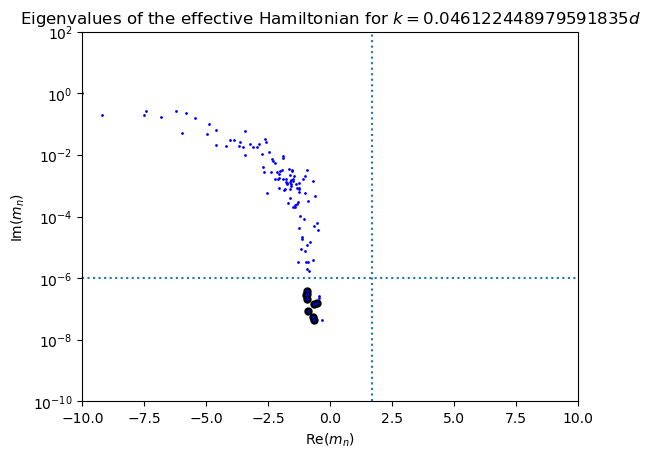

1.173131404914272
1.0521463365878883
1.0266731142258174
0.9512671697975486
0.9417542865741888
0.8623551841427735
0.8398405473095996
0.7969360724439669
0.5886234025022876
0.5447953554657174
0.5226682082074432
0.5757972926114672
0.5717980198485009


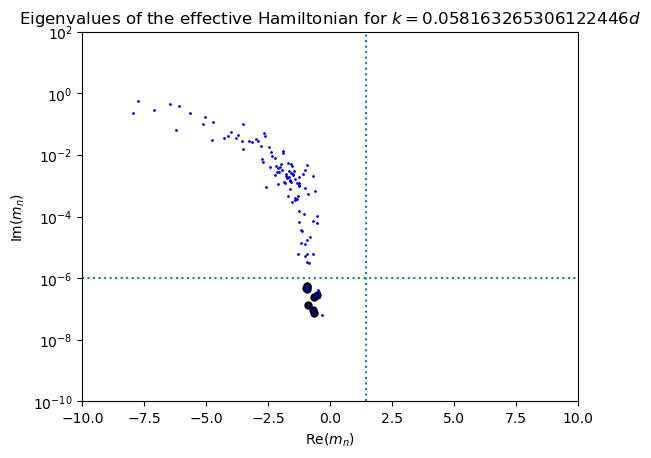

1.1721766009656176
1.0508741048321708
1.0253298361807892
0.9496857882158278
0.939822321422001
0.8602112756835161
0.837904696419622
0.7935744614604152
0.5856071445173185
0.5685484330416086
0.5725373770895437
0.5411251312189296
0.5187556412450167


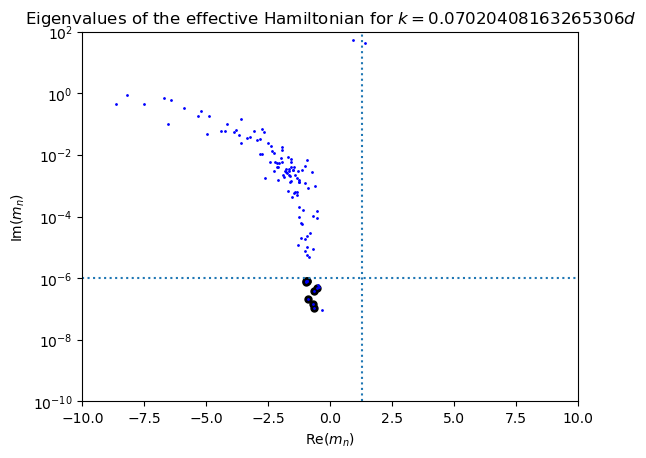

1.17103939123075
1.0493567626005893
1.023727618806149
0.94779778047657
0.9375125012622112
0.8576484675695251
0.8355940729929703
0.7894995861295313
0.5820030123739923


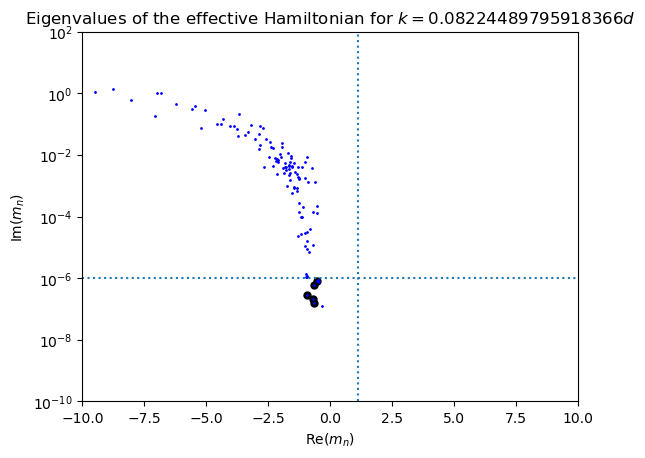

1.1697180119410742
0.9348164701688979
0.8546577003318923
0.8329024438620893
0.7846601265372073
0.577799198027716


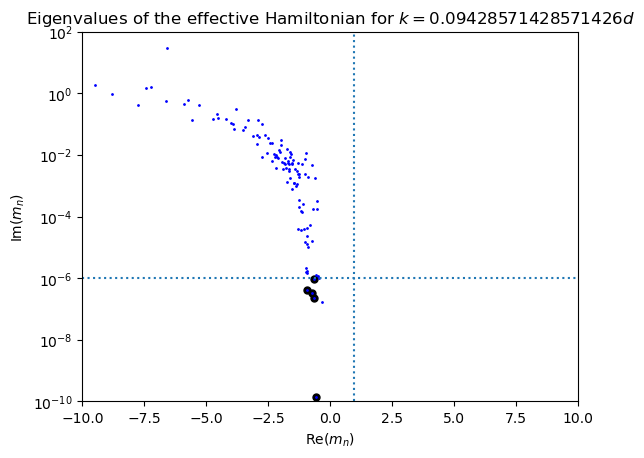

1.1682103580163936
0.9317241944331558
0.829822372640534
0.7789876638539646
0.5729816244803962


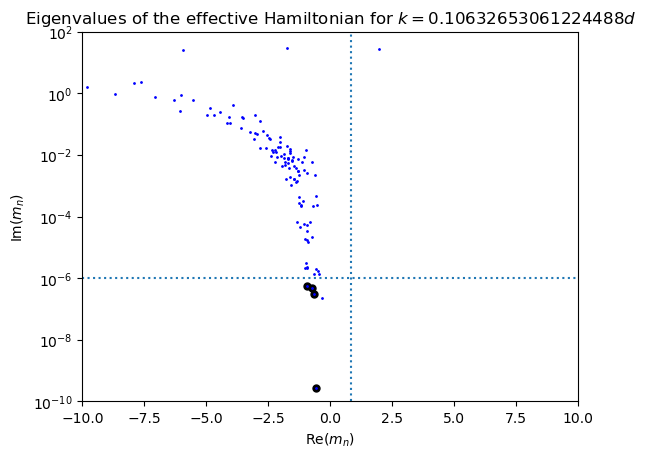

1.1665139493625774
0.9282237776946245
0.8263451082089317
0.7723898894634142
0.5675337316227849


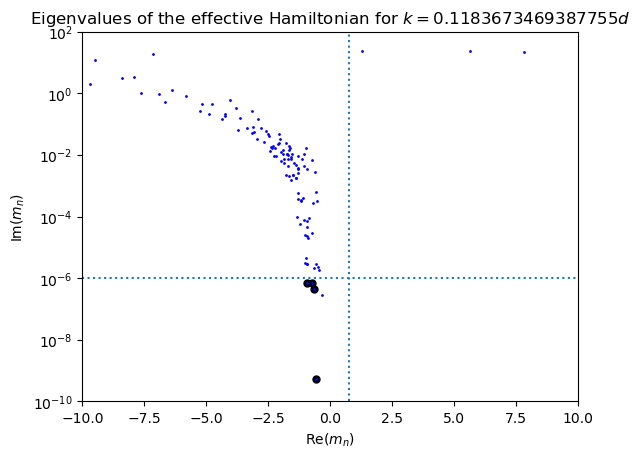

1.1646258872522373
0.9243012283075152
0.8224604452239983
0.5614361937315249


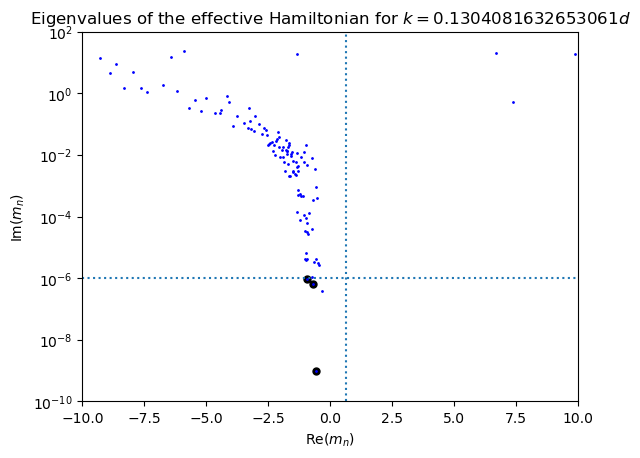

1.1625427976822713
0.9199401661860216
0.8181565492557412


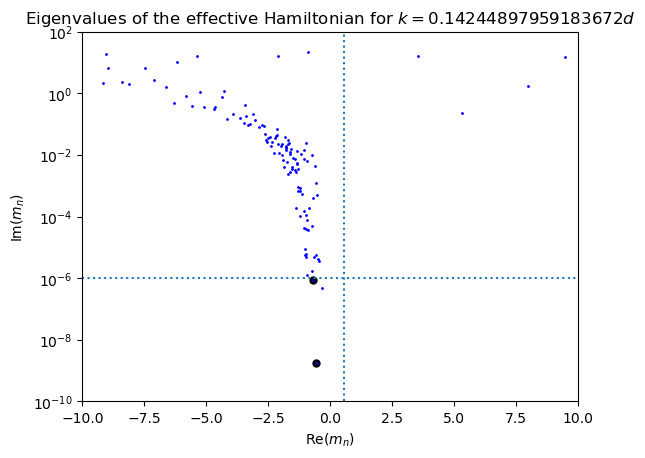

1.1602607571179204
0.915121451036303


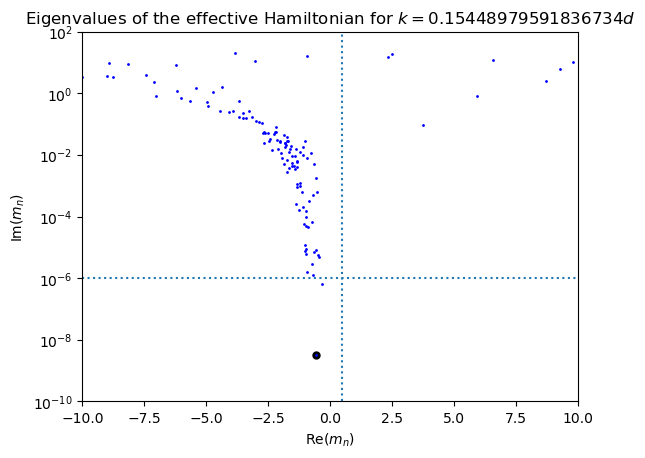

1.1577751938052838
0.9098227052471741


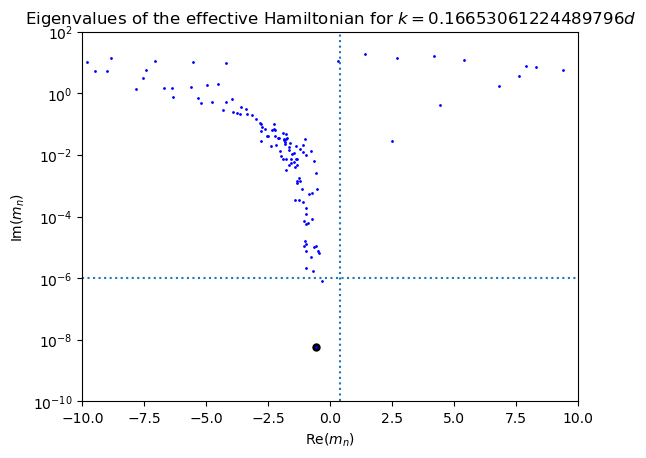

0.9040176889596437


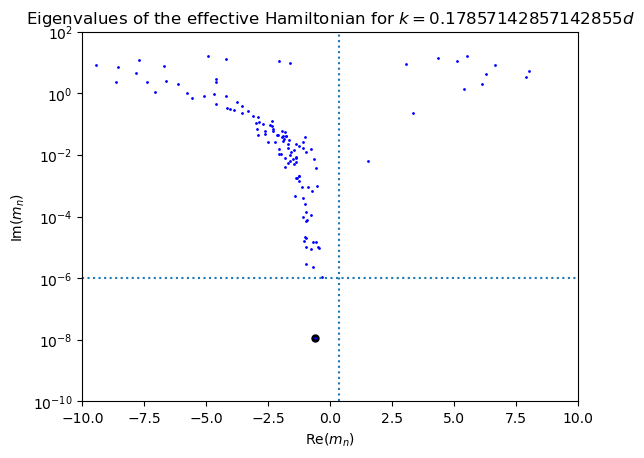

0.8976754495565591


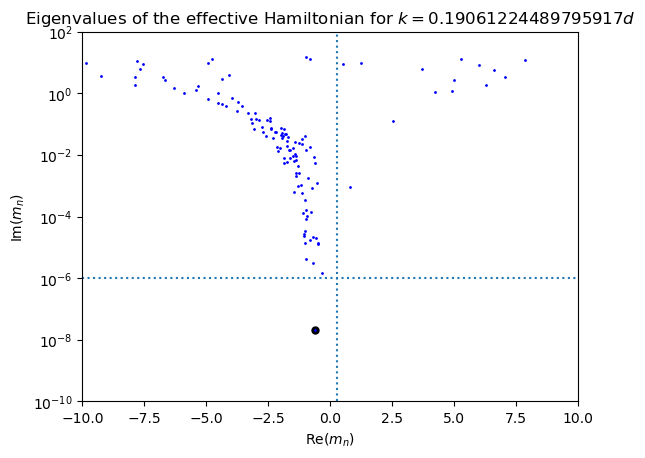

0.8907590568227913


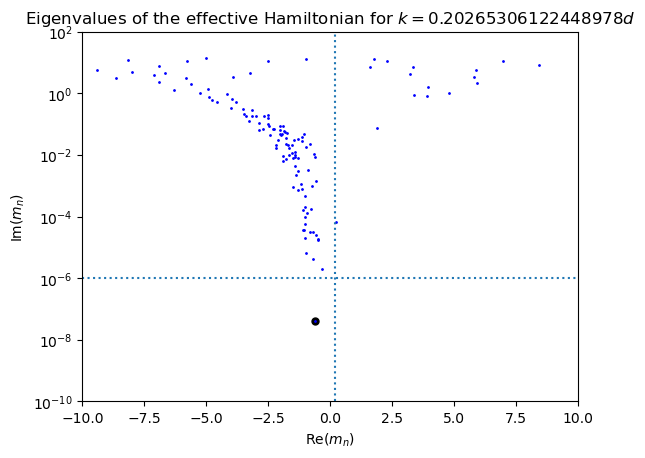

0.8832231460696803


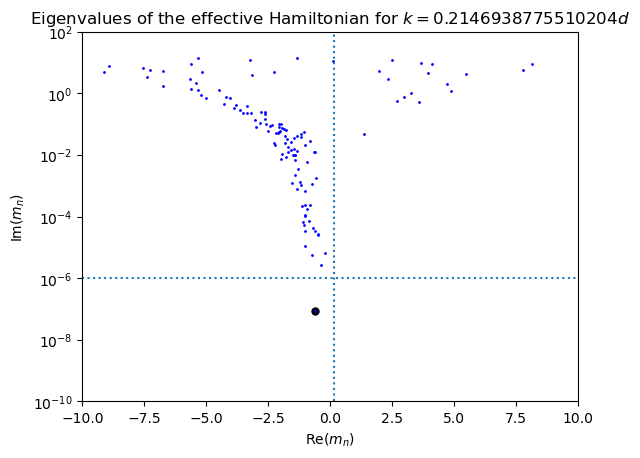

0.8750015376680339


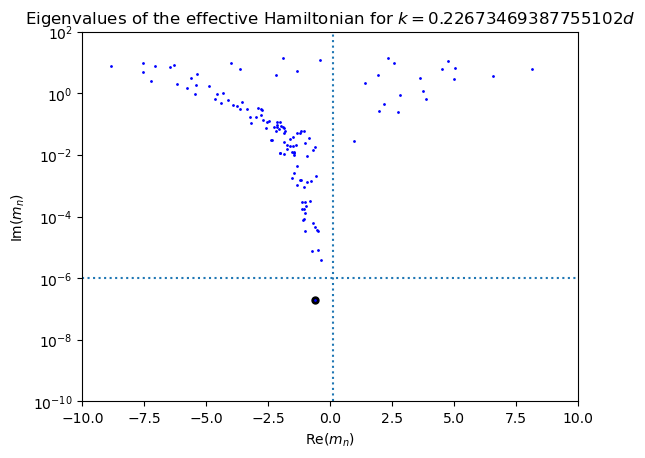

0.8661808931370258


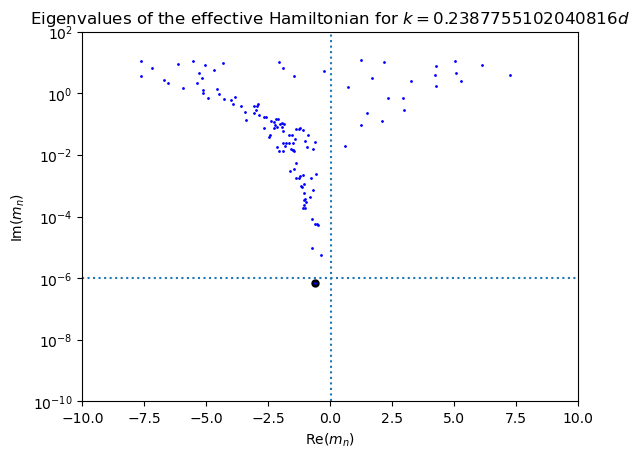

0.8563773548350623


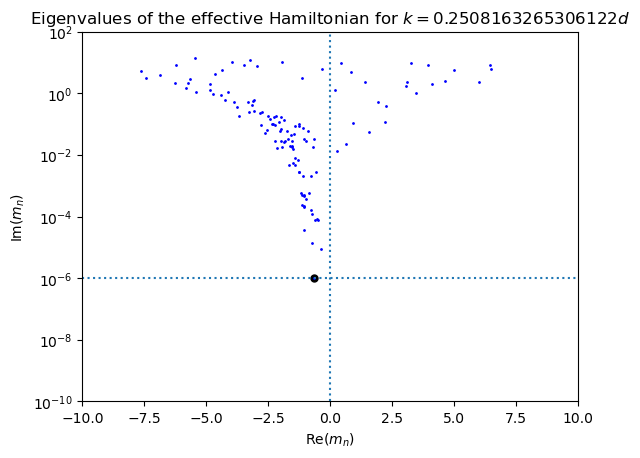

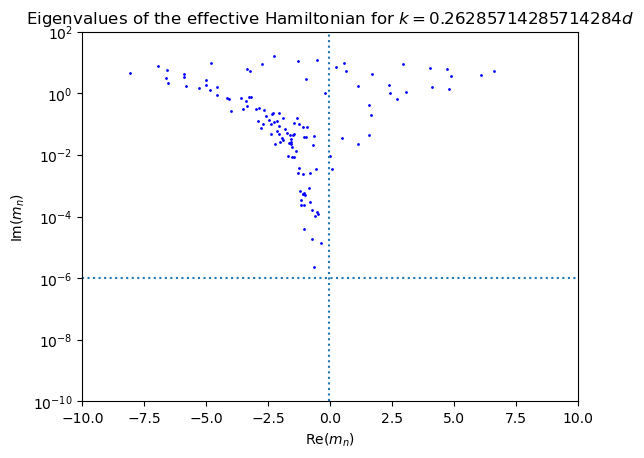

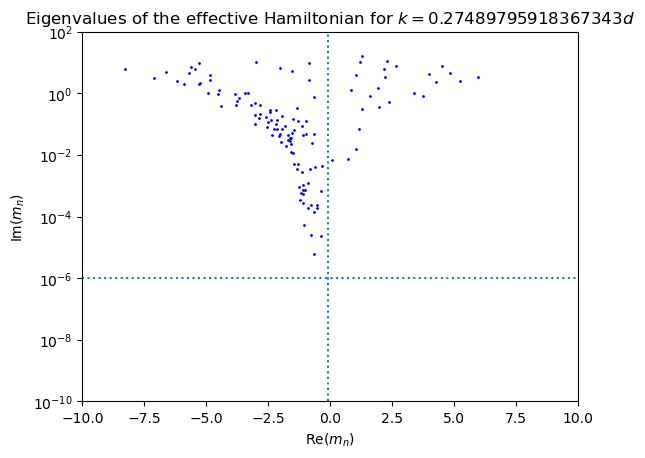

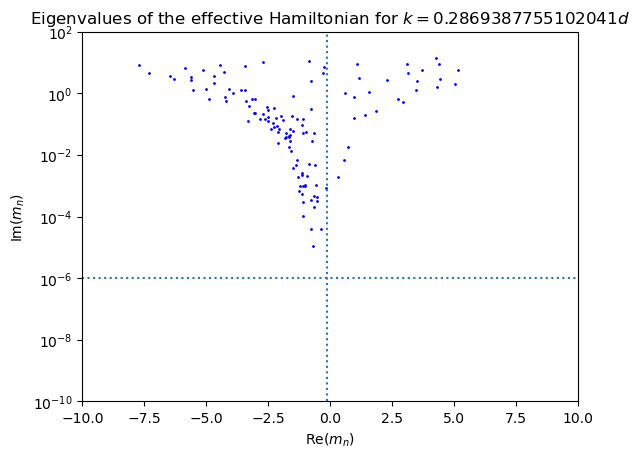

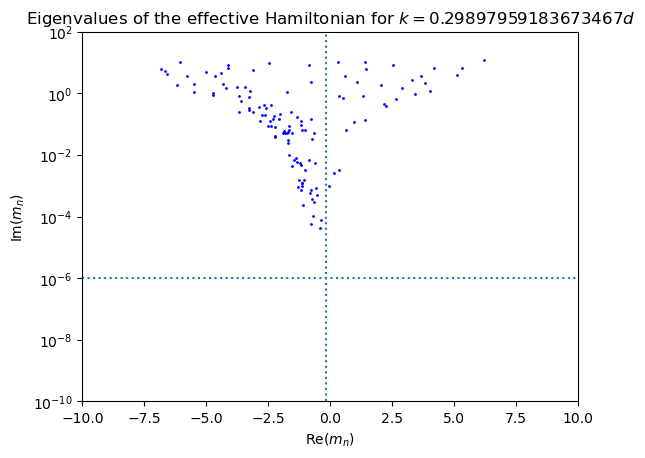

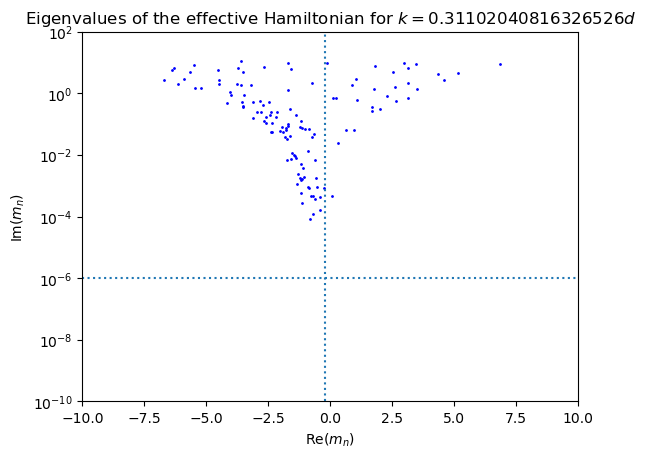

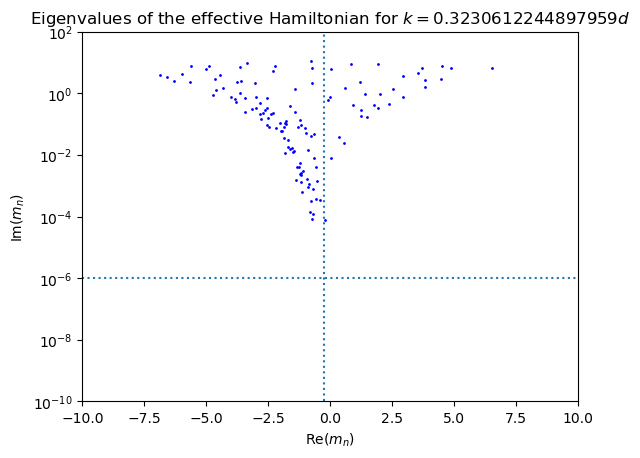

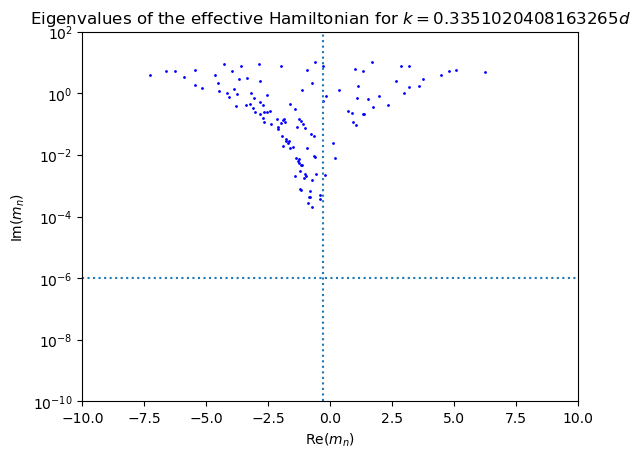

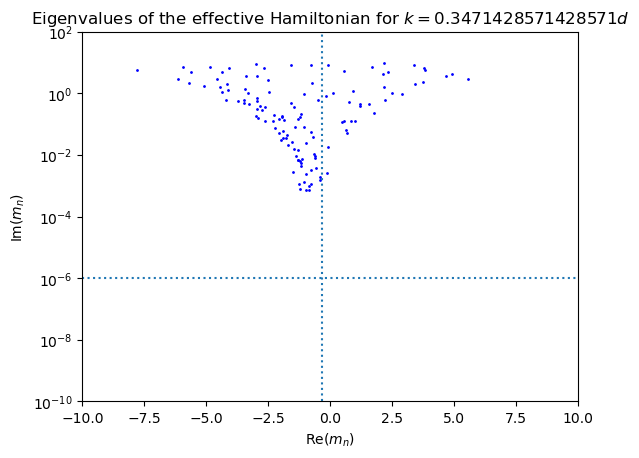

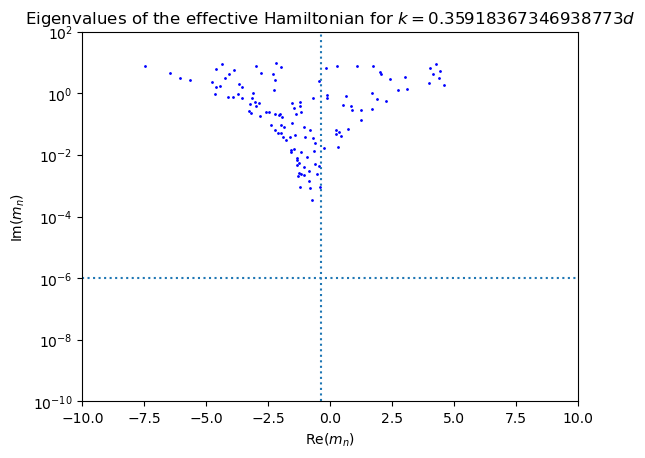

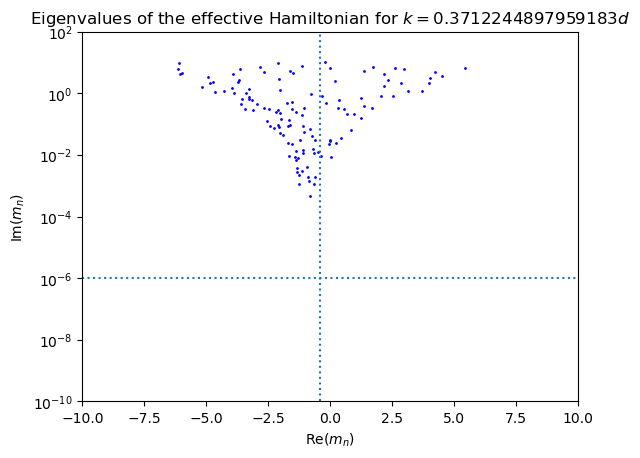

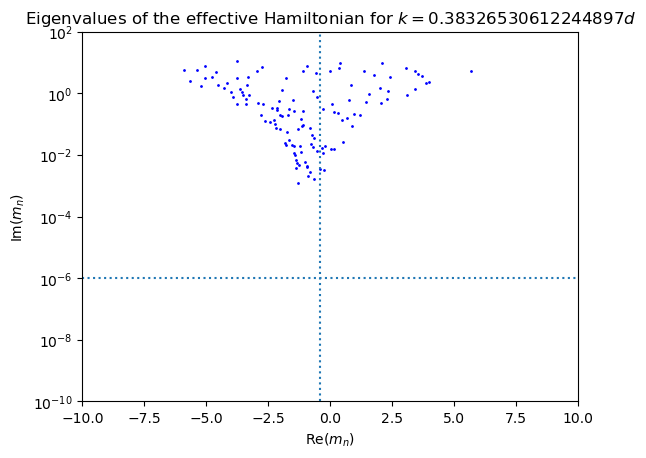

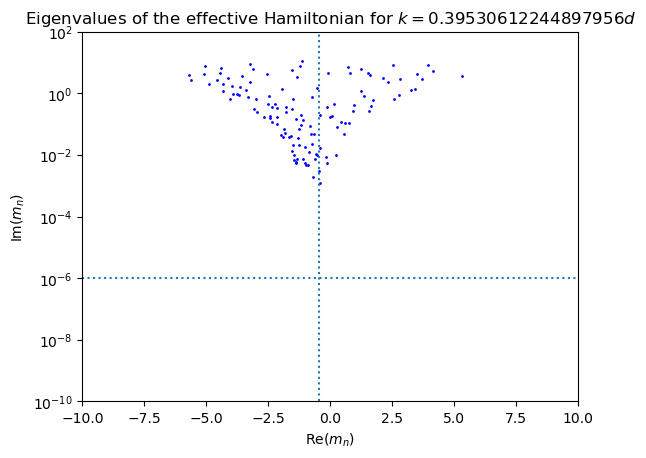

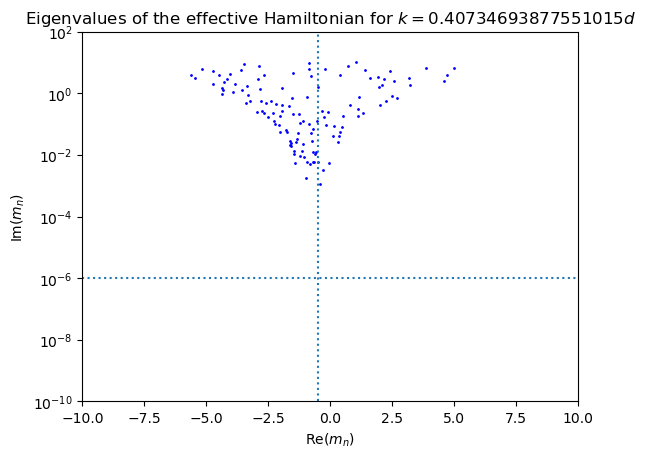

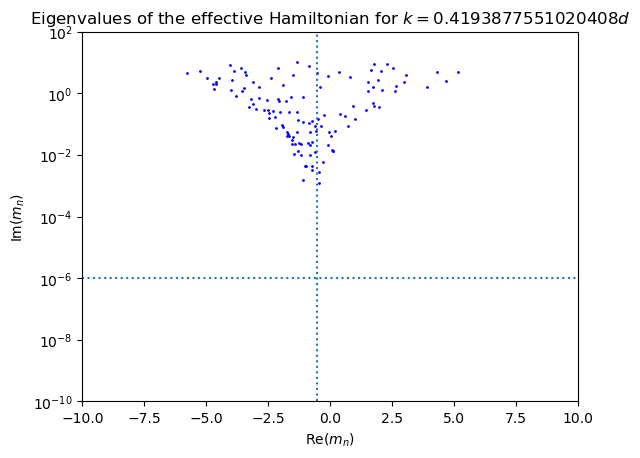

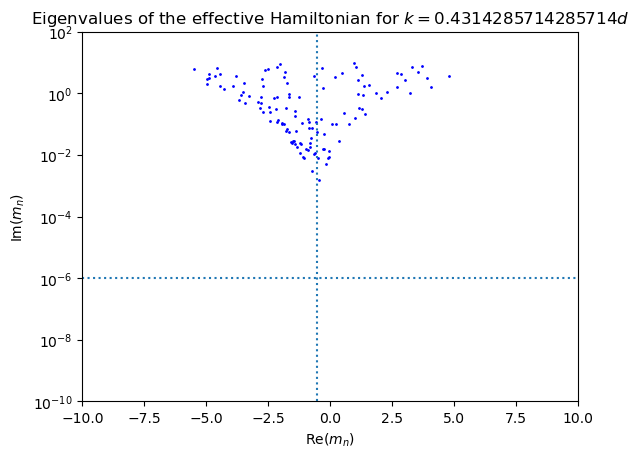

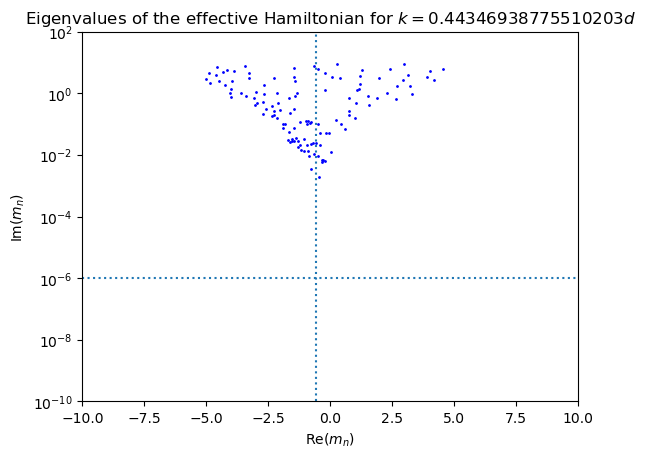

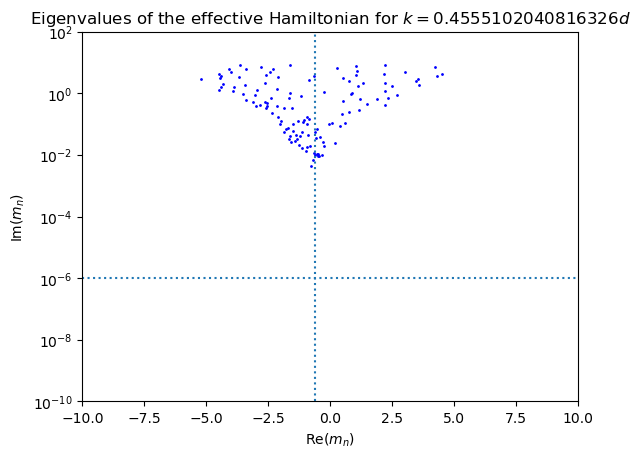

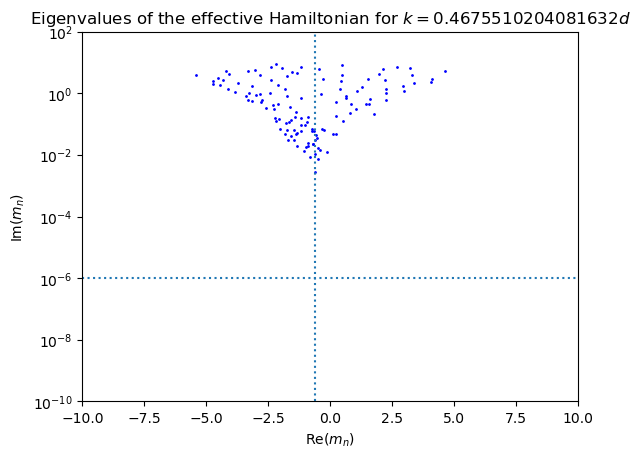

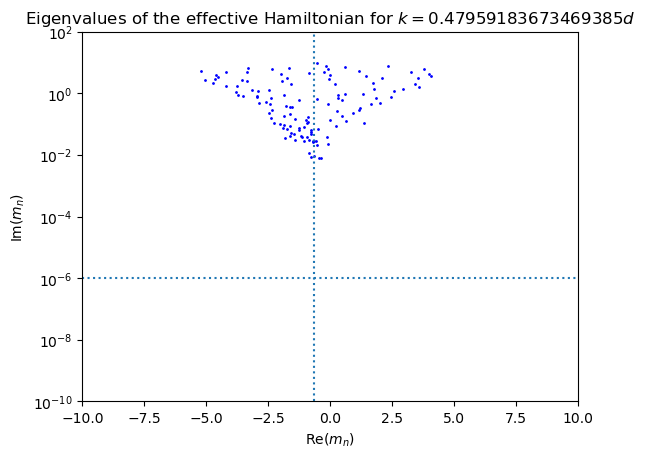

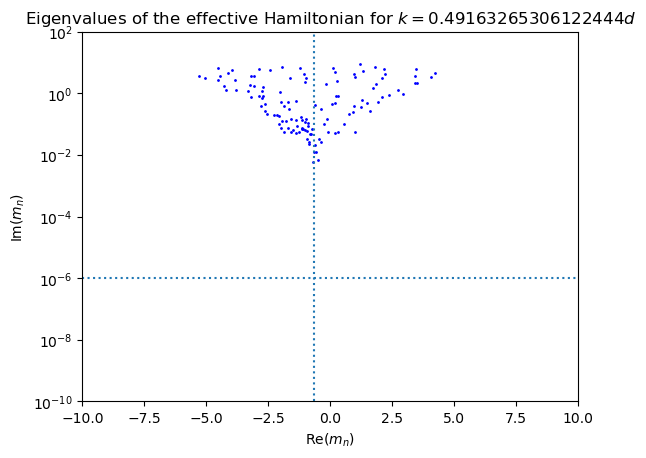

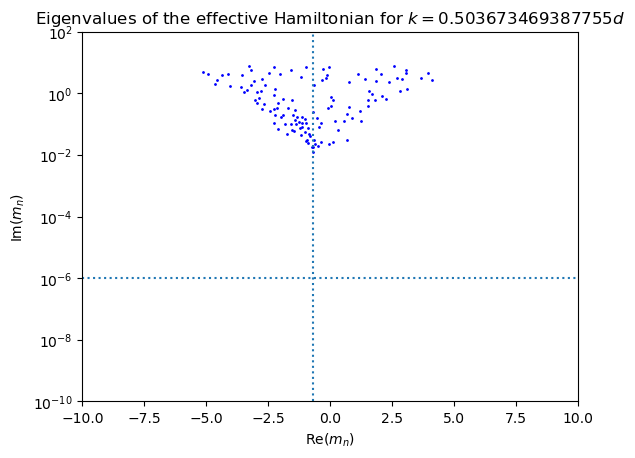

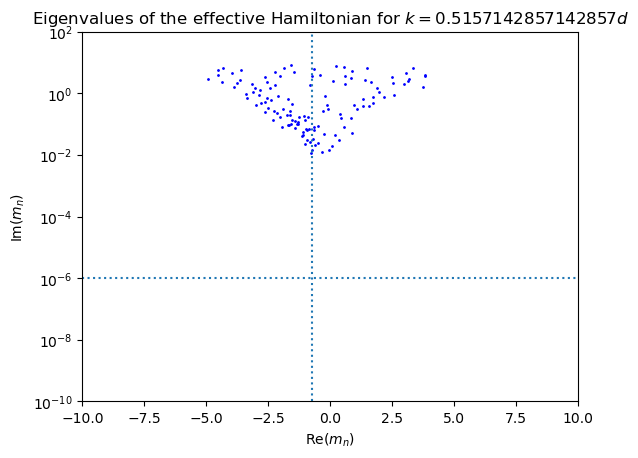

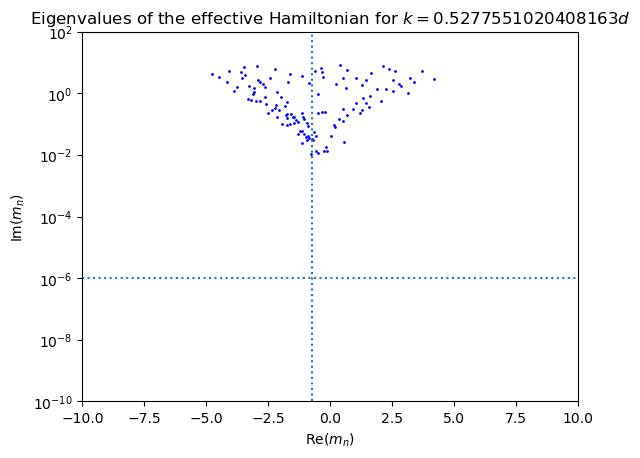

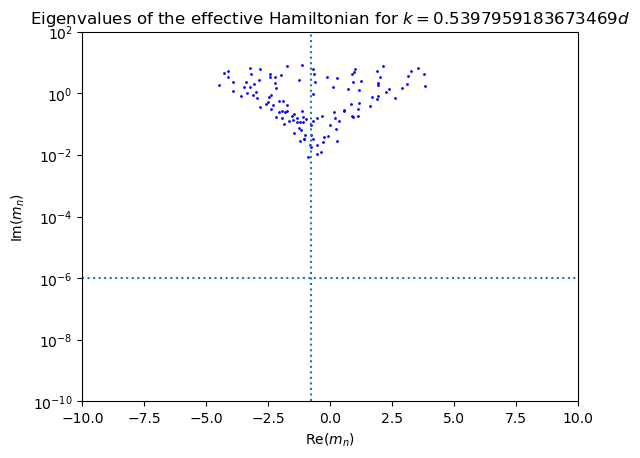

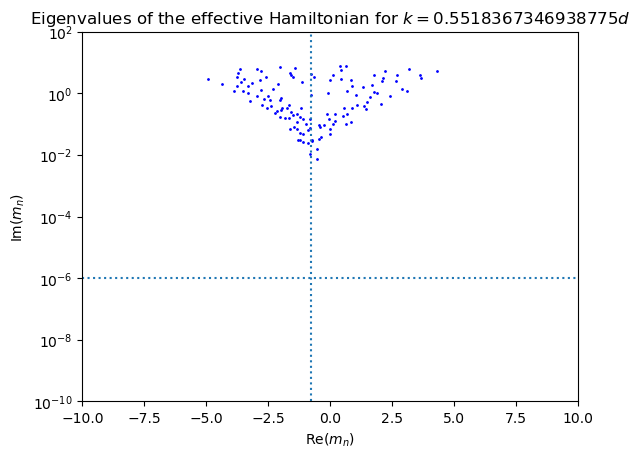

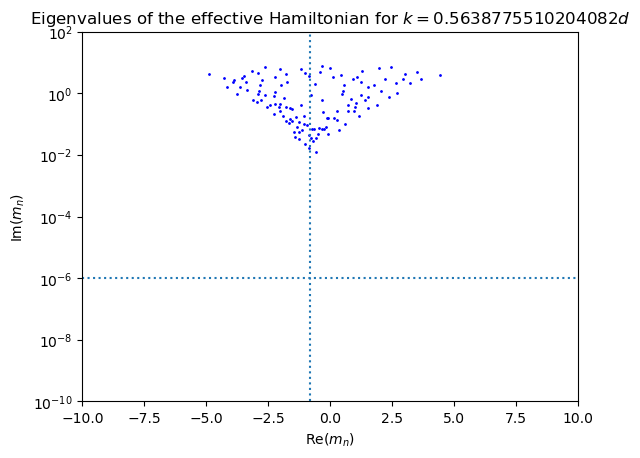

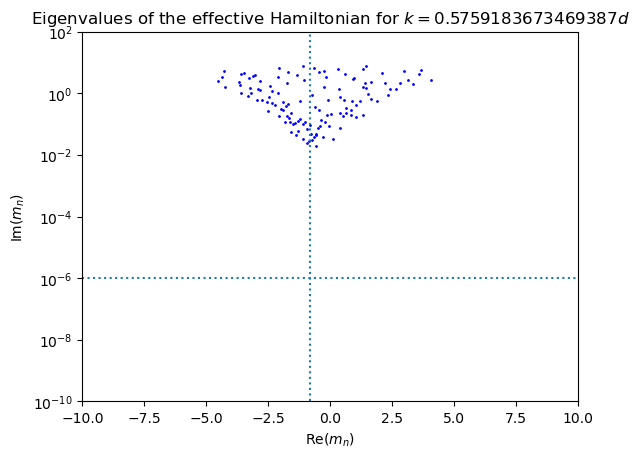

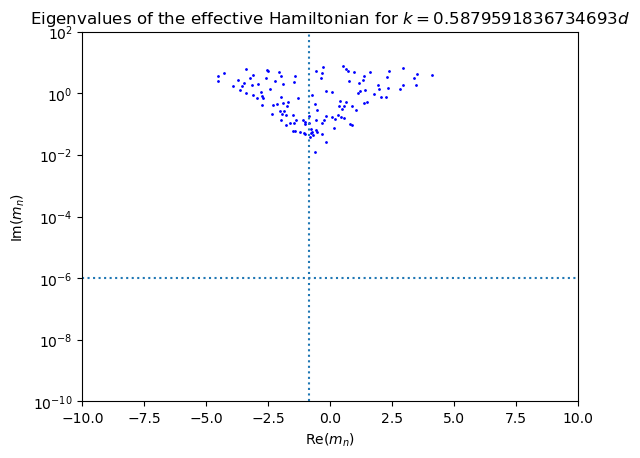

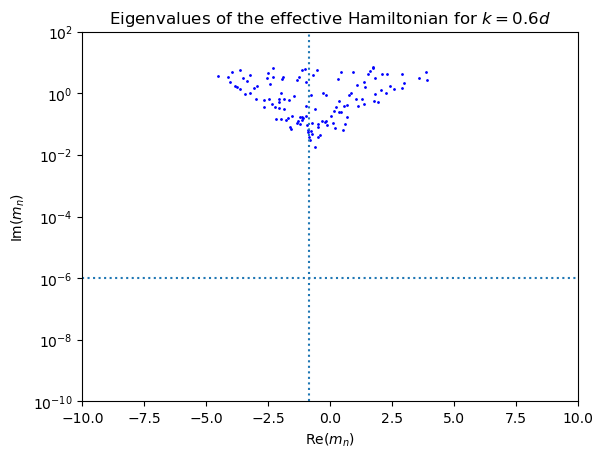

[18, 14, 11, 10, 10, 10, 6, 5, 4, 4, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


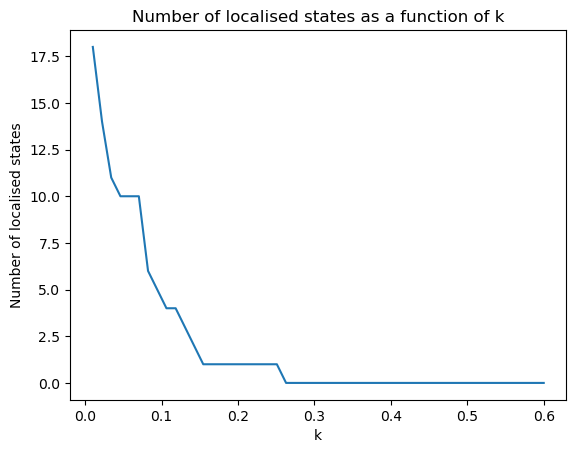

In [77]:
k=0.1
k_vals=np.linspace(0.01, 0.6, 50)
a_eff_vals=np.linspace(0.01, 5, 50)
# k_vals=[0.106]
loc_states_per_k=[]
a_eff=4.5
# for a_eff in a_eff_vals:
for k in k_vals:
    num_loc_states=0
    diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
    m_matrix = diag*np.eye(len(X_dispersors))+offdiag
    off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
    eigvals, eigvecs = np.linalg.eig(m_matrix)
    ones = np.ones(shape=off_diagonal_eigvals.shape)
    real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
    for i,q_n in enumerate(off_diag_eigvals):
        if (np.abs(np.imag(q_n)-np.pi/2)<1e-6):
            print(np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2)))
            if (np.abs(np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1):
                num_loc_states+=1
                plt.plot(np.real(off_diag_eigvals[i])+gamma_euler+np.log(k/2), np.abs(np.imag(real_eigvals[i])), 'ok',markersize=5)
    loc_states_per_k.append(num_loc_states)
    plt.plot(np.real(off_diag_eigvals)+gamma_euler+np.log(k/2), np.abs(np.imag(real_eigvals)), 'ob',markersize=1)
    plt.xlabel('Re($m_n$)')
    plt.ylabel('Im($m_n$)')
    plt.title(f'Eigenvalues of the effective Hamiltonian for $k={k}d$')
    plt.semilogy()
    plt.ylim(1e-10, 1e2)
    plt.xlim(-1e1, 1e1)
    # plt.xlim(-1,0)
    plt.hlines(1e-6, -1e1, 1e1, linestyles='dotted')
    plt.vlines(-(np.log(a_eff)+np.log(k/2)+gamma_euler), 1e-10, 1e2, linestyles='dotted')
    plt.show()
    
print(loc_states_per_k)
plt.plot(k_vals,loc_states_per_k)
plt.xlabel('k')
plt.ylabel('Number of localised states')
plt.title('Number of localised states as a function of k')
plt.show()

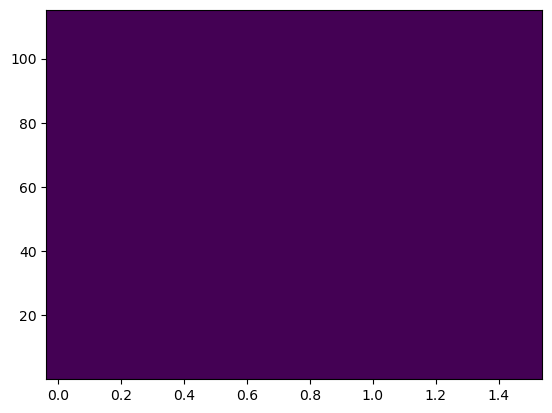

In [29]:
k_val=np.linspace(0.001, 1.5, 20)
a_eff_vals=np.linspace(-1, 2, 20)
num_loc_states_a_k=np.zeros((len(k_val), len(a_eff_vals)))
for i, k in enumerate(k_val):
    for j, a_eff in enumerate(a_eff_vals):
        num_loc_states=0
        diag,offdiag=generate_diag_off_diag_matrices(k, a_eff, X_dispersors, Y_dispersors)
        m_matrix = diag*np.eye(len(X_dispersors))+offdiag
        off_diag_eigvals, off_diagonal_eigvecs = np.linalg.eig(offdiag)
        eigvals, eigvecs = np.linalg.eig(m_matrix)
        ones = np.ones(shape=off_diagonal_eigvals.shape)
        real_eigvals = (np.log(a_eff*k/2)+gamma_euler-1j*np.pi/2)*ones+off_diag_eigvals
        for q_n in off_diag_eigvals:
            if (np.abs(np.imag(q_n)-np.pi/2)<1e-6) and np.abs((np.real(q_n)+gamma_euler+np.log(k*a_eff/2))<1e-6):
                num_loc_states+=1
        num_loc_states_a_k[i,j]=num_loc_states
plt.pcolor(k_val, a_eff_vals, num_loc_states_a_k)

Defining the system of equations as:

$$\mathbf{M}\mathbf{D}=\mathbf{B}$$

Difference in imaginary part of eigenvalues: -1.5707963267948968
 value of i pi/2: 1.5707963267948966
difference in real part of eigenvalues: 0.9237892551815057
 value of ln(k*a_eff*exp(gamma_euler)): 0.9237892551815057


[]

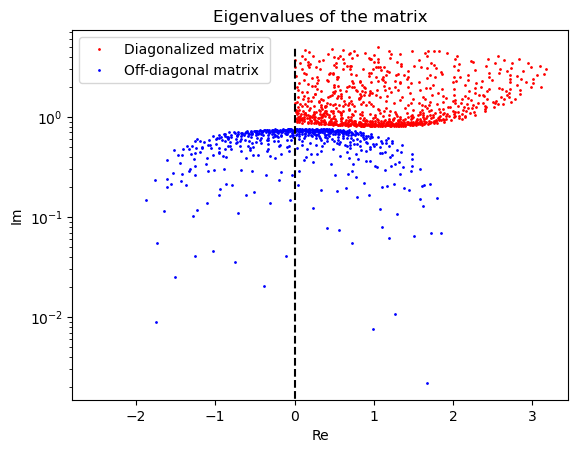

In [53]:
# diagonalize the matrix
eigenvalues, eigenvectors = np.linalg.eig(m_matrix)
# count localized modes
localized_modes = np.sum(np.imag(eigenvalues) < 1e-6)
plt.plot(np.abs(np.real(eigenvalues)), np.abs((np.imag(eigenvalues))), 'ro', markersize=1, label='Diagonalized matrix')

plt.plot(np.real(off_diagonal_eigvals), (np.imag(off_diagonal_eigvals)), 'bo', markersize=1, label='Off-diagonal matrix')
plt.hlines(0, linestyles='dashed', xmin=min(np.real(off_diagonal_eigvals)), xmax=max(np.real(eigenvalues)), colors='k')
plt.vlines(0, linestyles='dashed', ymin=0, ymax=5, colors='k')
imaginary_difference = np.mean(np.imag(eigenvalues) - np.imag(off_diagonal_eigvals))
print(f"Difference in imaginary part of eigenvalues: {imaginary_difference}")
print(f" value of i pi/2: {np.pi/2}")
print(f"difference in real part of eigenvalues: {np.mean(np.real(eigenvalues) - np.real(off_diagonal_eigvals))}")
print(f" value of ln(k*a_eff*exp(gamma_euler)): {np.log(k*a_eff*np.exp(gamma_euler))}")
plt.title('Eigenvalues of the matrix')
plt.xlabel('Re')
plt.ylabel('Im')
plt.legend()
plt.semilogy()

In [ ]:
r0 = np.array([-10, 5])

B_vector = np.zeros(len(X_dispersors), dtype=np.complex128)

for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
    B_vector[i] = 1j*np.pi/2*hankel1(0, k*np.sqrt((x-r0[0])**2+(y-r0[1])**2))
    
D_vector = np.linalg.solve(m_matrix, B_vector)

Text(0.5, 0, 'Dispersor index $i$')

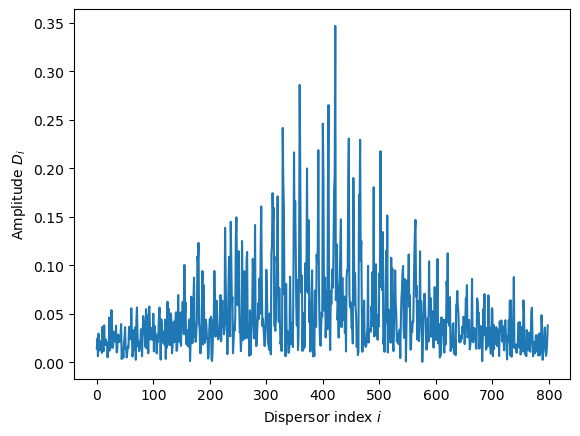

In [ ]:
plt.plot(np.abs(D_vector))
plt.ylabel(r'Amplitude $D_i$')
plt.xlabel(r'Dispersor index $i$')

Text(0.5, 1.0, 'Magnitude of the scattered field')

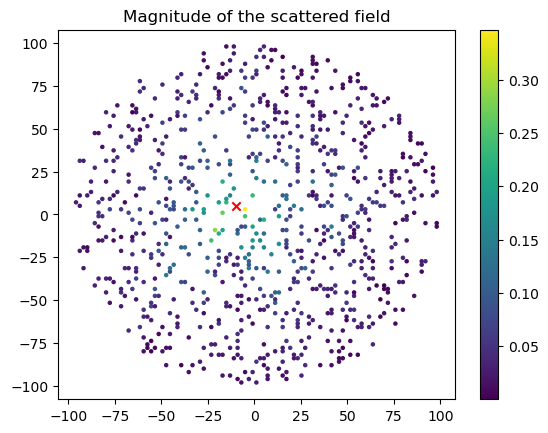

In [ ]:
plt.figure()
plt.scatter(r0[0], r0[1], c='r', label='Source',marker='x')
# plt.scatter(X,Y, c="grey", s=1, label='Lattice points')
plt.scatter(X_dispersors, Y_dispersors, c=np.abs(D_vector), cmap='viridis',s=5)
# for i, (x, y) in enumerate(zip(X_dispersors, Y_dispersors)):
#     plt.text(x, y, f'{i}', fontsize=8)
plt.colorbar()
plt.title('Magnitude of the scattered field')
